# IBTrACS Dataset Getting Started
The following is a description of the dataset from the NOAA website:
> The International Best Track Archive for Climate Stewardship (IBTrACS) project is the most complete global collection of tropical cyclones available. It merges recent and historical tropical cyclone data from multiple agencies to create a unified, publicly available, best-track dataset that improves inter-agency comparisons. IBTrACS was developed collaboratively with all the World Meteorological Organization (WMO) Regional Specialized Meteorological Centres, as well as other organizations and individuals from around the world.  

If you are interested in learning more about the dataset, visit the [projects home page](https://www.ncei.noaa.gov/products/international-best-track-archive).

To get started with the ibtracs dataset, we call its associated function within the `datasets` module. This module contains several adapter functions which generate a ragged array version of a particular dataset making Lagrangian analysis much easier. 

To learn more about the `ragged array` data structure, visit the [Clouddrift homepage](https://clouddrift.org/).

Below we will leverage the ibtracs associated `datasets` module function and display the datasets coordinates, data variables and dimensions.

It should be noted that at times the word variable is used interchangeably for dimension.

In [1]:
import clouddrift as cd

# Generate the dataset and display it
ds = cd.datasets.ibtracs("v04r01", "LAST_3_YEARS")
ds

<xarray.Dataset> Size: 14MB
Dimensions:           (storm: 306, obs: 17576, quadrant: 4)
Coordinates:
    id                (storm) int64 2kB ...
    time              (obs) datetime64[ns] 141kB ...
Dimensions without coordinates: storm, obs, quadrant
Data variables: (12/161)
    numobs            (storm) int64 2kB ...
    sid               (storm) |S13 4kB ...
    season            (storm) float32 1kB ...
    number            (storm) int16 612B ...
    name              (storm) |S128 39kB ...
    source_usa        (storm) |S128 39kB ...
    ...                ...
    usa_seahgt        (obs) float32 70kB ...
    usa_searad        (obs, quadrant) float32 281kB ...
    storm_speed       (obs) float32 70kB ...
    storm_dir         (obs) float32 70kB ...
    lat               (obs) float32 70kB ...
    lon               (obs) float32 70kB ...
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Tue Feb 25 05:40:21 2025: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

If we inspect the dataset above we see 3 dimensions, `storm, obs and, quadrant`. The `storm` dimension is important because it's leveraged heavily by the processing and analysis functions provided by the library in identifying observations for the same entity. This would typically be named `row` but to stay true to the original dataset we decided to use `storm` instead of `row`. Because the doesn't match up with the expected variable name `row`, we must provide this mapping to the various analysis functions provided by the library, like the `subset` function.

Similarly, another important variable utilized by the analysis functions is the `rowsize` variable or `numobs`, as it is named in this dataset. Like the `row` variable, because this dimension doesn't utilize the standard variable name for determining the number of observations per storm/row, we must also provide this mapping to the analysis/processing functions.

To start things off, let's perform a common step in data analysis where we filter out information were not interested in analzying. For this example we select all observation within the year 2024 and which we'll utilize later for plotting. 

Note that in the `subset` function call below, we provide the variable mappings for the `row` and the `rowsize` variables. Without these, the function will not work properly and will end up throwing an exception since the variables `row` and `rowsize` cannot be found.

In [2]:
import numpy as np

# Select the data for the year 2024 only by using the ragged.subset method
year = 2024
ds = cd.ragged.subset(
    ds,
    {"time": (np.datetime64(f"{year}-01-01"), np.datetime64(f"{year}-12-31"))},
    row_dim_name="storm",
    rowsize_var_name="numobs"
)
ds

<xarray.Dataset> Size: 4MB
Dimensions:           (storm: 93, obs: 4780, quadrant: 4)
Coordinates:
    id                (storm) int64 744B 199 200 201 202 203 ... 288 289 290 291
    time              (obs) datetime64[ns] 38kB 2024-01-01T00:00:00.000039936...
Dimensions without coordinates: storm, obs, quadrant
Data variables: (12/161)
    numobs            (storm) int64 744B 29 153 57 155 25 21 ... 35 47 27 32 9
    sid               (storm) |S13 1kB ...
    season            (storm) float32 372B ...
    number            (storm) int16 186B ...
    name              (storm) |S128 12kB ...
    source_usa        (storm) |S128 12kB ...
    ...                ...
    usa_seahgt        (obs) float32 19kB ...
    usa_searad        (obs, quadrant) float32 76kB ...
    storm_speed       (obs) float32 19kB ...
    storm_dir         (obs) float32 19kB ...
    lat               (obs) float32 19kB ...
    lon               (obs) float32 19kB ...
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Tue Feb 25 05:40:21 2025: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

Having the subset of data were interested in, lets go ahead and plot it!

Notice how we provide the `numobs` variable. This variable helps the function segment the `lon` and `lat` data variables correctly to capture each individual `storm` path. Typically here we would provide the `rowsize` variable but because this dataset utilizes a different mapping we provide `numobs` instead.

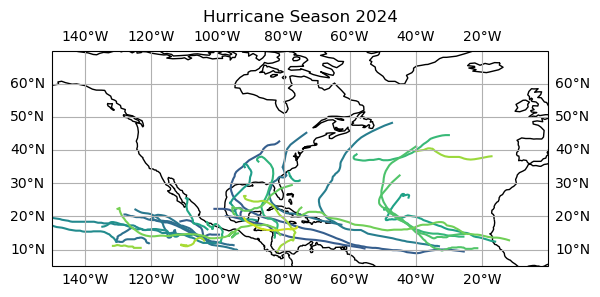

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# make figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
hl = cd.plotting.plot_ragged(
    ax,
    ds.lon,
    ds.lat,
    ds.numobs,
    transform=ccrs.PlateCarree(),
)
ax.set_extent([-150, 0, 5, 70], crs=ccrs.PlateCarree())
ax.set_title(f"Hurricane Season {year}")
ax.coastlines()
ax.gridlines(draw_labels=True)

Now that we've plotted a simple subset of the dataset, let's do something a bit more interesting like coloring the paths by each observations `wind_speed`.

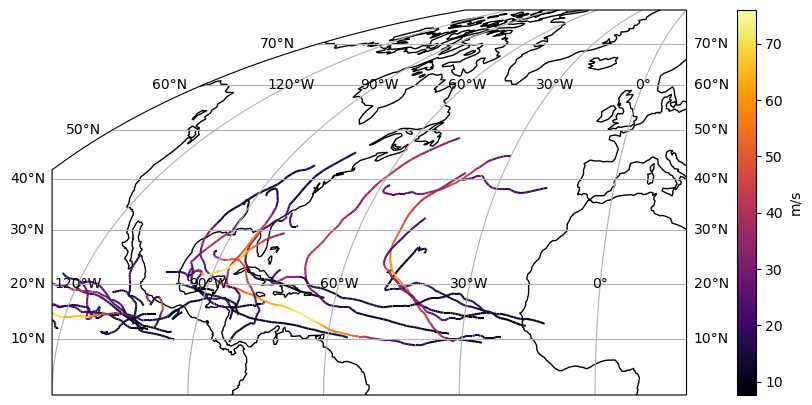

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


_METERS_IN_NAUTICAL_MILES = 1825

# Create the visualization
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude=30))
hl = cd.plotting.plot_ragged(
    ax,
    ds.lon,
    ds.lat,
    ds.numobs,
    colors=ds.usa_wind.values * _METERS_IN_NAUTICAL_MILES / 3600,
    transform=ccrs.PlateCarree(),
    cmap="inferno",
)
ax.set_extent([-120, 0, 0, 80], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.5, axes_class=plt.Axes)
fig.colorbar(hl, cax=cax, label="m/s")

This notebook showcases a small subset of features and capabilities provided by the library. To see what other analysis/processing functions are available you can checkout the [API documentation](https://clouddrift.org/api.html) to see what other tools are available to get you up and running with Lagrangian datasets.